In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
from sklearn.cluster import KMeans
import xarray as xr

import common.loss_utils as loss_utils
import common.climatehack_dataset as climatehack_dataset 

import sys
sys.path.append('./dgmr')
import dgmr


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
FORECAST = 24
INPUT_STEPS = 4
BATCH_SIZE = 4

In [5]:
p = pathlib.Path('data/train.npz')
f = np.load(p)
times = f['times']
data = f['data']


In [6]:
times.shape, data.shape

((41896,), (41896, 325, 400))

In [7]:
torch.manual_seed(7)
tsfm = transforms.Compose([
    transforms.Normalize(240.3414, 146.52366),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.ColorJitter(brightness=0.5, contrast=0.5),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # can shift up/down by 128*0.1 = 12.8 pixels
])

In [8]:
def check_times(tstart, tend):
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, tsfm, random_state=7):
        self.times = times
        self.data = data
        self.tsfm = tsfm
        self.generator = np.random.RandomState(random_state)
        
        
    def _get_crop(self, data):
        # roughly over the mainland UK
        rand_x = self.generator.randint(0, data.shape[2] - 128)
        rand_y = self.generator.randint(0, data.shape[1] - 128)
        # make a data selection
        return data[:, rand_y : rand_y + 128, rand_x : rand_x + 128]

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        all_data = self.data[index:index+INPUT_STEPS+24]
        all_data = self._get_crop(all_data)
        # -1 means rotate cw 90, 0 means no rotation, 1 means ccw 90, 2 means ccw 180
#         rot_amount = self.generator.randint(-1, 3)
#         if rot_amount != 0:
#             all_data = np.rot90(all_data, k=rot_amount, axes=(1, 2)).copy()
        # generate contrast and brightness changes
#         cf = np.random.uniform(low=0.7, high=1.3)
#         bf = np.random.uniform(low=-50, high=50)
#         all_data = all_data * cf + bf

        all_data = torch.FloatTensor(all_data)
        all_data = self.tsfm(all_data)
        x = all_data[:INPUT_STEPS]
        y = all_data[INPUT_STEPS:INPUT_STEPS+FORECAST]
        # add a satellite dimension
        x = torch.unsqueeze(x, dim=1)
        y = torch.unsqueeze(y, dim=1)
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = CustomTensorDataset(times, data, tsfm)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=4,
    prefetch_factor=4
)


In [9]:
x, y = ds[0]

In [10]:
x.shape, y.shape

(torch.Size([4, 1, 128, 128]), torch.Size([24, 1, 128, 128]))

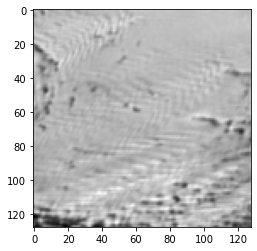

In [11]:
plt.imshow(x[-1,0], cmap='gray')

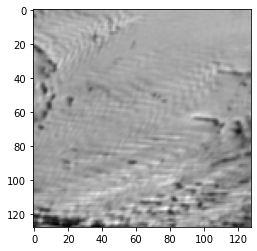

In [12]:
plt.imshow(y[0,0], cmap='gray')

In [13]:
model = dgmr.DGMR(
    forecast_steps=FORECAST,
    input_channels=1,
    output_shape=128,
    latent_channels=192,#384
    context_channels=96,#192,
    num_samples=3,
)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 8326277 trainable parameters


In [44]:
import pytorch_lightning as pl

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath='weights/dgmr_128_wd_lightning/',
    save_weights_only=True,
    every_n_train_steps=300,
    filename='dgmr_{epoch:03d}-{train/grid_loss:03f}',
    monitor="train/grid_loss",
    mode="min",
)

callbacks = [checkpoint_callback]

trainer = pl.Trainer(max_epochs=100, gpus=1, enable_checkpointing=True, callbacks=callbacks)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [45]:
trainer.fit(model=model, train_dataloaders=dl, )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type                     | Params
----------------------------------------------------------------
0 | discriminator_loss | NowcastingLoss           | 0     
1 | grid_regularizer   | GridCellLoss             | 0     
2 | conditioning_stack | ContextConditioningStack | 263 K 
3 | latent_stack       | LatentConditioningStack  | 452 K 
4 | sampler            | Sampler                  | 2.6 M 
5 | generator          | Generator                | 3.4 M 
6 | discriminator      | Discriminator            | 5.0 M 
----------------------------------------------------------------
8.3 M     Trainable params
0         Non-trainable params
8.3 M     Total params
33.305    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [29]:
trainer.fit(model=model, train_dataloaders=dl, )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type                     | Params
----------------------------------------------------------------
0 | discriminator_loss | NowcastingLoss           | 0     
1 | grid_regularizer   | GridCellLoss             | 0     
2 | conditioning_stack | ContextConditioningStack | 263 K 
3 | latent_stack       | LatentConditioningStack  | 452 K 
4 | sampler            | Sampler                  | 2.6 M 
5 | generator          | Generator                | 3.4 M 
6 | discriminator      | Discriminator            | 5.0 M 
----------------------------------------------------------------
8.3 M     Trainable params
0         Non-trainable params
8.3 M     Total params
33.305    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [46]:
def get_mssim(y, x, average=True):
    assert len(y.shape) == 5
    if average:
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=y.shape[1])
        return criterion(y, x)
    else:
        scores = []
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=1)
        for i in range(y.shape[1]):
            score = criterion(y[:,i:i+1], x[:,i:i+1])
            scores.append(score.item())
        return scores

In [47]:
LOOKS = int(500/BATCH_SIZE)

In [48]:
_MEAN_PIXEL = 240.3414
_STD_PIXEL = 146.52366


In [56]:
preds = []
for _ in range(6):
    with torch.no_grad():
        p = model(x)
        preds.append(p)

In [62]:
o = torch.mean(torch.stack(preds, dim=0), dim=0)

In [65]:
get_mssim(o, y)

tensor(0.1844, device='cuda:0')

In [67]:
get_mssim(p, y)

tensor(0.1947, device='cuda:0')

In [ ]:
torch.mean(preds)

In [57]:
p.shape

torch.Size([4, 24, 1, 128, 128])

In [76]:
criterion = loss_utils.MS_SSIM(
    data_range=1023.0, size_average=True, win_size=3, channel=24)

scores = []
running_total = 0
running_count = 0
pbar = tqdm.tqdm(dl, total=LOOKS)
for i, (srcs, trgs) in enumerate(pbar):
    if i > LOOKS:
        break
    x = srcs.float().to(DEVICE)
    y = trgs.float().to(DEVICE)
    
    preds = []
    for i in range(6):
        with torch.no_grad():
            p = model(x)
            preds.append(p)
    preds = torch.mean(torch.stack(preds, dim=0), dim=0)
        
#     b, t, c, h, w = preds.shape
#     preds = preds.reshape(b, t*c, h, w)
#     preds = final_layer(preds)
#     preds = preds.reshape(b, t, c, preds.shape[-2], preds.shape[-1])
#     preds = torch.tanh(preds)
    
#     y = torch.atanh(y) * _IQR + _MEDIAN_PIXEL
#     preds = torch.atanh(preds) * _IQR + _MEDIAN_PIXEL
    y = y * _STD_PIXEL + _MEAN_PIXEL
    preds = preds * _STD_PIXEL + _MEAN_PIXEL
    score = get_mssim(preds[:,:,:,32:96,32:96], y[:,:,:,32:96,32:96], average=False)
    scores.append(score)
    
    running_total += np.mean(score)
    running_count += 1
    
    pbar.set_description(f'Avg Score: {running_total/running_count}')
    


  0%|          | 0/125 [00:00<?, ?it/s]/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")

Avg Score: 0.6932433738510839:  77%|███████▋  | 96/125 [02:52<00:50,  1.74s/it]


Avg Score: 0.6850231320119253: 100%|██████████| 125/125 [03:42<00:00,  1.74s/it]
Avg Score: 0.6850231320119253: : 126it [03:42,  1.77s/it]                       


In [77]:
scores = np.array(scores)
scores.mean()

0.6850231320119251

In [20]:
scores = np.array(scores)
scores.mean()

0.7211647604902586

In [78]:
step_dgmr = scores.mean(axis=0)
step_dgmr

array([0.84095544, 0.80573478, 0.77455216, 0.74926097, 0.73081454,
       0.71602575, 0.70435895, 0.69286306, 0.68386237, 0.67681334,
       0.67048436, 0.66488212, 0.65990583, 0.65565165, 0.65203529,
       0.64953175, 0.64671744, 0.64346243, 0.64070088, 0.63802726,
       0.63689689, 0.63585153, 0.63568928, 0.6354771 ])

In [21]:
step_dgmr = scores.mean(axis=0)
step_dgmr

array([0.88808423, 0.84359666, 0.80962373, 0.78430165, 0.76478692,
       0.74942935, 0.73725223, 0.72707069, 0.71880875, 0.71140787,
       0.70507984, 0.69928792, 0.69429667, 0.69037542, 0.68724521,
       0.68448823, 0.68207624, 0.67996146, 0.67851938, 0.67718302,
       0.67557922, 0.67385908, 0.672978  , 0.67266248])

In [32]:
step = np.array([0.94732114, 0.8874218 , 0.8358762 , 0.79312605, 0.75684718,
       0.7254723 , 0.71111752, 0.69969728, 0.68989919, 0.68185381,
       0.67520599, 0.66936791, 0.66448703, 0.66054242, 0.65703949,
       0.65408842, 0.65171868, 0.6504889 , 0.64866001, 0.64693765,
       0.64587313, 0.6450839 , 0.64387597, 0.64268631])

In [33]:
choice = 3
np.array(step[:choice].tolist() + step_dgmr[choice:].tolist()).mean()

0.7371805847726879

In [37]:
out = preds.detach().cpu().numpy()
true = y.detach().cpu().numpy()

out = np.squeeze(out)
true = np.squeeze(true)

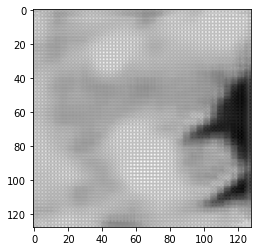

In [38]:
plt.imshow(out[1,0], cmap='gray')

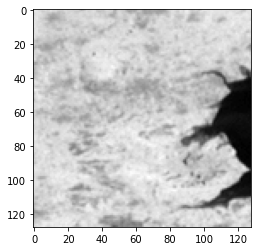

In [39]:
plt.imshow(true[1,0], cmap='gray')

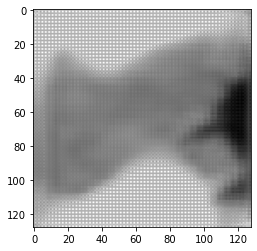

In [40]:
plt.imshow(out[1,-1], cmap='gray')

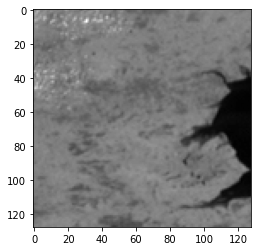

In [41]:
plt.imshow(true[1,-1], cmap='gray')